# Transformer Network
A neural network that takes advantage of parallel processing and substantially speeds up the training process. We first build functions for individual pieces, then tie them all together.  

**Full Encoder** (`Encoder`) = Word Embedded Input + Positional Encoding + Dropout + (Multiple) Encoder Layers
- Positional Encoding (`get_angles -> positional_encoding`) - returns a matrix (1, input_positions, position_encoding_length)   
- Encoder Layer (`EncoderLayer`) - combines MultiHeadAttention + LayerNorm + FFN + Dropout + LayerNorm
- Padding Mask (`create_padding_mask`) - so that padded values of 0, get -1e9 before feeding into softmax layer  
- Look ahead Mask (`create_look_ahead_mask`) - to pretend during training that the entire output sequence is not known  
- Self-Attention (`scaled_dot_product_attention`) - creates the self-attention vectors $A(Q, K,V)$   

**Full Decoder** (`Decoder`) = Word Embedded Input + Positional Encoding + (Multiple) Decoder Layers
- Decoder Layer (`DecoderLayer`)- combines 2 MultiHeadAttention layers + LayerNorm + FFN

<img src="images/transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Transformer Encoder & Decoder</font></center></caption></img>


In [1]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
# from transformers import DistilBertTokenizerFast #, TFDistilBertModel
# from transformers import TFDistilBertForTokenClassification

---
## 1. Positional Encoding

In sequence to sequence tasks, the relative order of data is extremely important to its meaning. When we were training sequential neural networks such as RNNs, we fed the inputs into the network in order. Information about the order of your data was automatically fed into your model. However, in a Transformer network using multi-head attention, data is fed all at once and *there is no information about the order of the data.* This is where positional encoding is useful - we can encode the positions of our inputs and pass them into the network using these sine and cosine formulas:
    
The sum of the positional encoding and word embedding is ultimately what is fed into the model. If we just hard code the positions in, say by adding a matrix of 1's or whole numbers to the word embedding, the semantic meaning is distorted. Conversely, the values of the sine and cosine equations are small enough (between -1 and 1) that when we add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. 

*(In the lectures Andrew uses vertical vectors, but in this code all vectors are horizontal. All matrix multiplications should be adjusted accordingly.)*

$$PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$
$$PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$.

Notice that the inner terms for both equations are the same. E.g., angles for $PE_{(pos, 2)}$ and $PE_{(pos, 3)}$ are same.  
$$\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}}$$

Function `get_angles()` to calculate the possible angles for the sine and cosine positional encodings

In [2]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
            # k refers to each of the different dimensions in the positional encodings
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos/(10000**(2*i/d))    
    return angles

In [3]:
# position = 2
# d_model = 4
# pos_m = np.arange(position)[:, np.newaxis]
# dims = np.arange(d_model)[np.newaxis, :]
# get_angles(pos_m, dims, d_model)

In [4]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    positions (int) -- Maximum number of positions to be encoded 
    d (int) -- Encoding size 
    pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],  # pos
                            np.arange(d)[np.newaxis, :],          # k
                            d)                                    # d
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


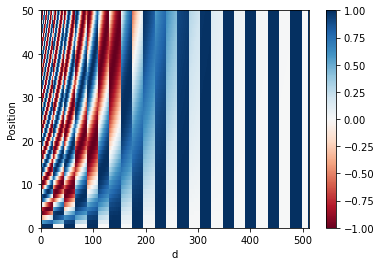

In [5]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

---
## 2. Masking

There are two types of masks that are useful when building a Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in the input sentence. 

### Padding Mask

Oftentimes the input sequence will exceed the maximum length of a sequence our network can process. Let's say the maximum length of our model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],    <-- Note, truncated part included as a new vector
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! We will need to define a **boolean mask** that specifies which elements we must **attend(1)** and which elements you must **ignore(0)**. Later we will use that mask to set all the zeros in the sequence to a value close to negative infinity (-1e9).

After masking, our input should go from `[87, 600, 0, 0, 0]` to `[87, 600, -1e9, -1e9, -1e9]`, so that when we take the softmax, the zeros don't affect the score. (exp(-1e9) ~ 0)

The [MultiheadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/) layer implemented in Keras, use this masking logic.

In [6]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    decoder_token_ids -- (n, m) matrix
    mask -- (n, 1, m) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
    # add extra dimensions to add the padding
    return seq[:, tf.newaxis, :] 

In [7]:
x = tf.constant([[7., 6., 0., 0., 1.],
                 [1., 2., 3., 0., 0.],
                 [0., 0., 0., 4., 5.]])
print(x.shape)
print(create_padding_mask(x))

(3, 5)
tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


If we multiply (1 - mask) by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity.

In [8]:
# raw = tf.keras.activations.softmax(x)
# clean = tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9)
# print(raw.numpy().round(2))
# print(clean.numpy().round(2))

### Look-ahead Mask

The look-ahead mask follows similar intuition. In training, we will have access to the complete correct output of your training example. The look-ahead mask helps our model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output. 

For example, if the expected correct output is `[1, 2, 3]` and we wanted to see if given that the model correctly predicted the first value it could predict the second value, we would mask out the second and third values. So our input would be the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

In [9]:
def create_look_ahead_mask(sequence_length):
    """
    Returns an lower triangular matrix filled with ones
    sequence_length -- matrix size
    mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [10]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
print(temp.shape, temp)

(1, 3, 3) tf.Tensor(
[[[1. 0. 0.]
  [1. 1. 0.]
  [1. 1. 1.]]], shape=(1, 3, 3), dtype=float32)


---
## 3. Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

<img src="images/self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks processing allows for parallelization which speeds up training. We will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in our sequence. This type of self-attention can be mathematically expressed as:
$$\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

In [11]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key   shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v) where seq_len_k = seq_len_v.
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.
    Returns:
        output -- attention_weights
    """
    matmul_qk = tf.matmul(q,k.T)                    # (..., seq_len_q, seq_len_k)
    dk = k.shape[-1]
    
    # scake the tensor
    scaled_attention_logits = matmul_qk/np.sqrt(dk) # (..., seq_len_q, seq_len_k)

    # add the mask
    if mask is not None: 
        scaled_attention_logits += (1.-mask)*(-1e9)

    # softmax is normalized on the last axis (seq_len_k) so scores add to 1
    attention_weights = tf.keras.activations.softmax(scaled_attention_logits, 
                                                     axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)         # (..., seq_len_q, depth_v)

    return output, attention_weights

In [12]:
# q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
# k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
# v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)
# print(q.shape, k.shape, v.shape)

# matmul_qk = tf.matmul(q,k.T)
# print(matmul_qk.shape)
# print(matmul_qk)

# dk = k.shape[-1]
# np.sqrt(dk) 

# scaled_attention_logits = matmul_qk/np.sqrt(dk)
# print(scaled_attention_logits.shape)
# print(scaled_attention_logits)

# attention_weights = tf.keras.activations.softmax(scaled_attention_logits, axis=-1)
# print(attention_weights.shape)
# print(attention_weights)

# output = tf.matmul(attention_weights, v)
# print(output.shape)
# print(output)

---
## 4. Encoder

Transformer Encoder layer pairs **self-attention** and **convolutional neural network style of processing** to improve the speed of training and passes K and V matrices to the Decoder. First, we will implement the Encoder by pairing multi-head attention and a feed forward neural network 
* `MultiHeadAttention` computes the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

The input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.

<img src="images/encoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Transformer encoder layer</font></center></caption></img>
   
References:

* For the `MultiHeadAttention` layer, we use the [Keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). *Note that if query, key and value are the same, then this function performs self-attention* - **i.e. mha(x,x,x)**

* The call arguments for `self.mha` are (Where B is for batch_size, T is for target sequence shapes, and S is output_shape):
 - `query`: Query Tensor of shape (B, T, dim).
 - `value`: Value Tensor of shape (B, S, dim).
 - `key`: Optional key Tensor of shape (B, S, dim). If not given, will use value for both key and value, which is the most common case.
 - `attention_mask`: a boolean mask of shape (B, T, S), that prevents attention to certain positions. The boolean mask specifies which query elements can attend to which key elements, 1 indicates attention and 0 indicates no attention. Broadcasting can happen for the missing batch dimensions and the head dimension.
 - `return_attention_scores`: A boolean to indicate whether the output should be attention output if True, or (attention_output, attention_scores) if False. Defaults to False.

In [39]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)                            # (batch_size, seq_len, d_model)
    ])

In [40]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to True to activate training mode for dropout layers
            mask -- Boolean mask to ensure that padding is not treated as part of input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """
        # Calculate Self-attention using mha layer
        attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # Apply layer normalization on sum of input and  attention output
        out1 = self.layernorm1(x+attn_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # Pass output of multi-head attention layer through a ffn
        ffn_output = self.ffn(out1)            # (batch_size, input_seq_len, fully_connected_dim)
        
        # Apply dropout layer
        ffn_output = self.dropout_ffn(ffn_output, training)
        
        # Apply layer normalization on sum of o/p from multi-head attention and ffn
        encoder_layer_out = self.layernorm2(out1+ffn_output)  # (batch_size, input_seq_len, fully_connected_dim)
        
        print('--- Encoder layer ---')
        print('X dim: ', x.shape)
        print('Attn_output dim: ', attn_output.shape)
        print('Norm1 dim: ', out1.shape)
        print('FFN_out dim: ', ffn_output.shape)
        print('Encoder_layer_out dim: ', encoder_layer_out.shape)
        
        return encoder_layer_out
    

In [41]:
# Dimension Test
q = np.array([[[1, 0, 1, 1],
               [0, 1, 1, 1],
               [1, 0, 0, 1]]]).astype(np.float32)
print('Q dim: ', q.shape)

# Initializing Class instance
encoder_layer1 = EncoderLayer(4, 2, 8)

# Calling Class instance
tf.random.set_seed(10)
encoded = encoder_layer1(q, True, np.array([[1, 0, 1]]))     # NOTE - This is the call function
encoded

Q dim:  (1, 3, 4)
--- Encoder layer ---
X dim:  (1, 3, 4)
Attn_output dim:  (1, 3, 4)
Norm1 dim:  (1, 3, 4)
FFN_out dim:  (1, 3, 4)
Encoder_layer_out dim:  (1, 3, 4)


<tf.Tensor: shape=(1, 3, 4), dtype=float32, numpy=
array([[[ 0.23017097, -0.98100376, -0.7870757 ,  1.5379084 ],
        [-1.2280798 ,  0.76477593, -0.7169285 ,  1.1802324 ],
        [ 0.14880149, -0.48318025, -1.19084   ,  1.525219  ]]],
      dtype=float32)>

---
## 5. Full Encoder

Now we're ready to build the full Transformer Encoder, where we will embedd our input and add the positional encodings we calculated. We will then feed your encoded embeddings to a stack of Encoder layers. 

<img src="images/encoder.png" alt="Encoder" width="330"/>
<caption><center><font color='purple'><b>Transformer Encoder</font></center></caption></img>

In [42]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """
        # mask, to match the dimension of pos_encoding (5) to input (3)
        # used in pos_encoding step down below
        seq_len = tf.shape(x)[1]
        print('--- Encoder ---')
        print('X shape: ', x.shape)
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        print('After Embedding: ', x.shape)
        
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= np.sqrt(tf.cast(x.shape[2], dtype=tf.float32))
        
        # Add the position encoding to embedding
        x += self.pos_encoding[0,:seq_len,:]
        print('After Positional Encoding: ', x.shape)
        
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)
        print('After Dropout: ', x.shape)
        
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        print('After Encoding stack: ', x.shape)
        
        return x  # (batch_size, input_seq_len, fully_connected_dim)

In [43]:
tf.random.set_seed(10)
embedding_dim=4
encoderq = Encoder(num_layers=2,
                  embedding_dim=embedding_dim,
                  num_heads=2,
                  fully_connected_dim=8,
                  input_vocab_size=32,
                  maximum_position_encoding=5)
x = np.array([[2, 1, 3], [1, 2, 0]])

encoderq_output = encoderq(x, True, None)
encoderq_output

--- Encoder ---
X shape:  (2, 3)
After Embedding:  (2, 3, 4)
After Positional Encoding:  (2, 3, 4)
After Dropout:  (2, 3, 4)
--- Encoder layer ---
X dim:  (2, 3, 4)
Attn_output dim:  (2, 3, 4)
Norm1 dim:  (2, 3, 4)
FFN_out dim:  (2, 3, 4)
Encoder_layer_out dim:  (2, 3, 4)
--- Encoder layer ---
X dim:  (2, 3, 4)
Attn_output dim:  (2, 3, 4)
Norm1 dim:  (2, 3, 4)
FFN_out dim:  (2, 3, 4)
Encoder_layer_out dim:  (2, 3, 4)
After Encoding stack:  (2, 3, 4)


<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[-0.69061005,  1.098871  , -1.2605861 ,  0.8523252 ],
        [ 0.73192257, -0.3826024 , -1.4507655 ,  1.1014453 ],
        [ 1.0995711 , -1.1686685 , -0.8088867 ,  0.8779842 ]],

       [[-0.46129382,  1.069736  , -1.4127711 ,  0.8043292 ],
        [ 0.2702725 ,  0.28793636, -1.637089  ,  1.0788802 ],
        [ 1.2370992 , -1.0687275 , -0.89450395,  0.7261322 ]]],
      dtype=float32)>

---
## 6. Decoder

The Decoder layer comprises two multi-head attention layers. It takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output.
* The first two blocks are fairly similar to the EncoderLayer except we will return `attention_scores` when computing self-attention

<img src="images/decoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Transformer Decoder layer</font></center></caption></img>



In [44]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output -- Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # shape = (batch_size, input_seq_len, [fully_connected_dim/d_model])
        
        # BLOCK 1
        # Calculate self-attention (return attention scores) + LayerNorm
        # Dropout will be applied during training
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, 
                                                        return_attention_scores=True)  
        Q1 = self.layernorm1(mult_attn_out1 + x)
        
        # BLOCK 2
        # Calculate self-attention using the Q (first block) and K and V from the encoder output. 
        # Dropout will be applied during training
        # Apply layer normalization (layernorm2)
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, 
                                                        enc_output,padding_mask, 
                                                        return_attention_scores=True)
        mult_attn_out2 = self.layernorm2(mult_attn_out2 + Q1)
           
        #BLOCK 3
        # Pass through a FFN + Apply Dropput + Layer Norm
        ffn_output = self.ffn(mult_attn_out2)  
        ffn_output = self.dropout_ffn(ffn_output, training)
        out3 = self.layernorm3(ffn_output + mult_attn_out2) 
        
        print('--- Decoder Layer ---')
        print('X shape: ', x.shape)
        print('Multi_Attn_Op1 shape: ', mult_attn_out1.shape)
        print('Q1 shape: ', Q1.shape)
        print('Multi_Attn_Op2 shape: ', mult_attn_out2.shape)
        print('FFN shape: ', ffn_output.shape)
        print('Out3 shape: ', out3.shape)
        
        return out3, attn_weights_block1, attn_weights_block2

In [45]:
# Dimension Test
num_heads=8
tf.random.set_seed(10)
decoderLayerq = DecoderLayer(
    embedding_dim=4, 
    num_heads=num_heads,
    fully_connected_dim=32, 
    dropout_rate=0.1, 
    layernorm_eps=1e-6)
encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                               [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                               [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]]])
q = np.array([[[1, 0, 1, 1], 
               [0, 1, 1, 1], 
               [1, 0, 0, 1]]]).astype(np.float32)
look_ahead_mask = create_look_ahead_mask(q.shape[1])
padding_mask = None

out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output, True, look_ahead_mask, padding_mask)

print(out)

--- Decoder Layer ---
X shape:  (1, 3, 4)
Multi_Attn_Op1 shape:  (1, 3, 4)
Q1 shape:  (1, 3, 4)
Multi_Attn_Op2 shape:  (1, 3, 4)
FFN shape:  (1, 3, 4)
Out3 shape:  (1, 3, 4)
tf.Tensor(
[[[-0.22109613 -1.5455484   0.85269207  0.9139525 ]
  [-1.6134266   0.582021    1.0286384   0.00276712]
  [ 1.2321432  -0.8184075  -1.1359645   0.7222289 ]]], shape=(1, 3, 4), dtype=float32)


---
## 7. Full Decoder

<img src="images/decoder.png" alt="Encoder" width="300"/>
<caption><center><font color='purple'><b>Transformer Decoder</font></center></caption>



In [46]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the 'target' input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        print('--- Decoder ---')
        print('Encoder output shape: ', enc_output.shape)
        print('X shape: ', x.shape)
        
        # Create word embeddings 
        x = self.embedding(x)                 
        print('After Embedding: ', x.shape)
        
        # Scale embeddings
        x *= np.sqrt(tf.cast(x.shape[2], dtype=tf.float32))
        
        # Add Positional encodings
        x += self.pos_encoding[0,:seq_len,:]
        print('After Positional Encoding: ', x.shape)
        
        # Apply a dropout layer
        x = self.dropout(x, training)

        # A stack of decoder layers and update attention_weights
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, 
                                                   look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2

        
        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

In [47]:
num_layers=7                 # Number of times decoder network is run
embedding_dim=4              # Length for word embedding, to positional encoding, 
                             # to MHA (Size of each attention head for query and key)
                             # Fully Connected Layer ()
num_heads=3                  # Number of attention heads - parameter to Multi-Head Attention Layer
fully_connected_dim=8        # Nodes in 1st Dense layer of FFN
maximum_position_encoding=6  # should be >= embedding_dim
target_vocab_size=33

x = np.array([[3, 2, 1], 
              [2, 1, 0]])
encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                                [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                                [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]],
                               [[-0.3489219,   0.31335592, -1.3568854,   1.3924513 ],
                                [-0.08761203, -0.1680029,  -1.2742313,   1.5298463 ],
                                [ 0.2627198,  -1.6140151,   0.2212624 ,  1.130033  ]]])

look_ahead_mask = create_look_ahead_mask(x.shape[1])
decoderk = Decoder(num_layers,
                   embedding_dim, 
                   num_heads, 
                   fully_connected_dim,
                   target_vocab_size,
                   maximum_position_encoding)

outd, att_weights = decoderk(x, encoderq_output, False, look_ahead_mask, None)

--- Decoder ---
Encoder output shape:  (2, 3, 4)
X shape:  (2, 3)
After Embedding:  (2, 3, 4)
After Positional Encoding:  (2, 3, 4)
--- Decoder Layer ---
X shape:  (2, 3, 4)
Multi_Attn_Op1 shape:  (2, 3, 4)
Q1 shape:  (2, 3, 4)
Multi_Attn_Op2 shape:  (2, 3, 4)
FFN shape:  (2, 3, 4)
Out3 shape:  (2, 3, 4)
--- Decoder Layer ---
X shape:  (2, 3, 4)
Multi_Attn_Op1 shape:  (2, 3, 4)
Q1 shape:  (2, 3, 4)
Multi_Attn_Op2 shape:  (2, 3, 4)
FFN shape:  (2, 3, 4)
Out3 shape:  (2, 3, 4)
--- Decoder Layer ---
X shape:  (2, 3, 4)
Multi_Attn_Op1 shape:  (2, 3, 4)
Q1 shape:  (2, 3, 4)
Multi_Attn_Op2 shape:  (2, 3, 4)
FFN shape:  (2, 3, 4)
Out3 shape:  (2, 3, 4)
--- Decoder Layer ---
X shape:  (2, 3, 4)
Multi_Attn_Op1 shape:  (2, 3, 4)
Q1 shape:  (2, 3, 4)
Multi_Attn_Op2 shape:  (2, 3, 4)
FFN shape:  (2, 3, 4)
Out3 shape:  (2, 3, 4)
--- Decoder Layer ---
X shape:  (2, 3, 4)
Multi_Attn_Op1 shape:  (2, 3, 4)
Q1 shape:  (2, 3, 4)
Multi_Attn_Op2 shape:  (2, 3, 4)
FFN shape:  (2, 3, 4)
Out3 shape:  (2, 3, 4

---
## 8 Transformer
The flow of data through the Transformer Architecture is as follows:
* First input passes through an Encoder, which is just repeated Encoder layers:
    - embedding and positional encoding of input
    - multi-head attention on the input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers:
    - embedding and positional encoding of the output
    - multi-head attention on the generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in sequence.

In [50]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            output_sentence -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure padding is not treated as part of input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        
        Returns:
            final_output --
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # Run Encoder - Input Sentence
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)
        
        # Run Decoder - Output Sentence + Encoder Input
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax
        final_output = self.final_layer(dec_output)
        
        print(' --- Transformer ---')
        print('Encoder output :', enc_output.shape)
        print('Decoder output :', enc_output.shape)
        print('Final output :', final_output.shape)

        return final_output, attention_weights

In [51]:
# Dimension Test
num_layers = 6
embedding_dim = 4
num_heads = 4
fully_connected_dim = 8
input_vocab_size = 30
target_vocab_size = 35
max_positional_encoding_input = 5
max_positional_encoding_target = 6

trans = Transformer(num_layers, 
                    embedding_dim, 
                    num_heads, 
                    fully_connected_dim, 
                    input_vocab_size, 
                    target_vocab_size, 
                    max_positional_encoding_input,
                    max_positional_encoding_target)
# 0 is the padding value
sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
sentence_lang_b = np.array([[3, 2, 1, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_lang_a)
dec_padding_mask = create_padding_mask(sentence_lang_b)

look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])

translation, weights = trans(
    sentence_lang_a,
    sentence_lang_b,
    True,  # Training
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)


--- Encoder ---
X shape:  (1, 5)
After Embedding:  (1, 5, 4)
After Positional Encoding:  (1, 5, 4)
After Dropout:  (1, 5, 4)
--- Encoder layer ---
X dim:  (1, 5, 4)
Attn_output dim:  (1, 5, 4)
Norm1 dim:  (1, 5, 4)
FFN_out dim:  (1, 5, 4)
Encoder_layer_out dim:  (1, 5, 4)
--- Encoder layer ---
X dim:  (1, 5, 4)
Attn_output dim:  (1, 5, 4)
Norm1 dim:  (1, 5, 4)
FFN_out dim:  (1, 5, 4)
Encoder_layer_out dim:  (1, 5, 4)
--- Encoder layer ---
X dim:  (1, 5, 4)
Attn_output dim:  (1, 5, 4)
Norm1 dim:  (1, 5, 4)
FFN_out dim:  (1, 5, 4)
Encoder_layer_out dim:  (1, 5, 4)
--- Encoder layer ---
X dim:  (1, 5, 4)
Attn_output dim:  (1, 5, 4)
Norm1 dim:  (1, 5, 4)
FFN_out dim:  (1, 5, 4)
Encoder_layer_out dim:  (1, 5, 4)
--- Encoder layer ---
X dim:  (1, 5, 4)
Attn_output dim:  (1, 5, 4)
Norm1 dim:  (1, 5, 4)
FFN_out dim:  (1, 5, 4)
Encoder_layer_out dim:  (1, 5, 4)
--- Encoder layer ---
X dim:  (1, 5, 4)
Attn_output dim:  (1, 5, 4)
Norm1 dim:  (1, 5, 4)
FFN_out dim:  (1, 5, 4)
Encoder_layer_out dim